In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator

train_directory = "Downloads/dog-breed-identification/train"
test_directory = "Downloads/dog-breed-identification/test"

train_labels = pd.read_csv("Downloads/dog-breed-identification/labels.csv", dtype=str)
test_labels = pd.read_csv("Downloads/dog-breed-identification/sample_submission.csv", dtype=str)

train_labels['id'] = train_labels['id'].apply(lambda x : x + '.jpg')
test_labels['id'] = test_labels['id'].apply(lambda x : x + '.jpg')

In [2]:
train_labels.head(5) # testing to see if .jpg extension has been applied. 

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


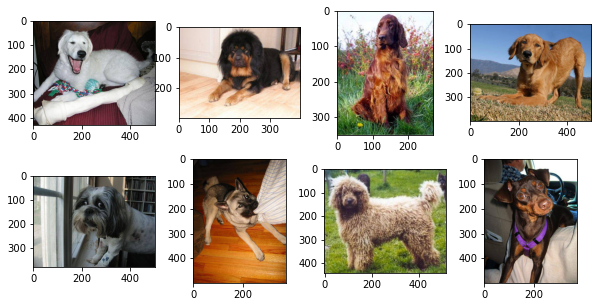

In [3]:
# mayhaps some dog pics?

import matplotlib.pyplot as plt
import os
import sys
%matplotlib inline

subclass = os.listdir(train_directory)

img = plt.figure(figsize=(10,5))
for e in range(len(subclass[:8])):
    plt.subplot(2, 4, e+1)
    dog = plt.imread(os.path.join(train_directory, subclass[e]))
    plt.imshow(dog, cmap=plt.get_cmap('gray'))

In [4]:
EPOCHS = 10
BATCH_SIZE = 32
TARGET_SIZE = (256, 256)

train_generator = ImageDataGenerator(rescale = 1./255., 
                                    validation_split = 0.05)

dogs_train = train_generator.flow_from_dataframe(dataframe = train_labels, 
                                                directory = train_directory, 
                                                x_col = "id", 
                                                y_col = "breed", 
                                                subset = "training", 
                                                batch_size = BATCH_SIZE, 
                                                seed = 42, 
                                                shuffle = True, 
                                                class_mode = "categorical", 
                                                target_size = TARGET_SIZE, 
                                                interpolation = "nearest",
                                                save_to_dir = "Downloads/dog-breed-identification/generated",
                                                save_prefix = "", 
                                                save_format = "jpg",
                                                color_mode = "rgb")

Found 9711 validated image filenames belonging to 120 classes.


In [5]:
x, y = next(dogs_train)
print(x.shape)
print(y.shape)

(32, 256, 256, 3)
(32, 120)


In [6]:
validation_generator = train_generator.flow_from_dataframe(dataframe = train_labels, 
                                                          directory = train_directory, 
                                                          x_col = "id", 
                                                          y_col = "breed", 
                                                          subset = "validation",
                                                          batch_size = BATCH_SIZE, 
                                                          seed = 42, 
                                                          shuffle = True, 
                                                          class_mode = "categorical", 
                                                          target_size = TARGET_SIZE, 
                                                          color_mode = "rgb")

Found 511 validated image filenames belonging to 120 classes.


In [7]:
test_generator = train_generator.flow_from_dataframe(dataframe = test_labels,
                                                     directory = test_directory,
                                                     x_col = "id",
                                                     y_col = None,
                                                     batch_size = BATCH_SIZE,
                                                     seed = 42,
                                                     shuffle = False,
                                                     class_mode = None,
                                                     target_size = TARGET_SIZE,
                                                     color_mode = "rgb")

Found 10357 validated image filenames.


In [8]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2

baseline = InceptionResNetV2(include_top = False,
                             weights ='imagenet',
                             input_shape = (256, 256, 3))
baseline.trainable = False

In [9]:
from keras.models import Sequential
from keras.layers import Dense,MaxPooling2D,Dropout,Conv2D,GlobalAveragePooling2D,Flatten

model = Sequential()
model.add(baseline)
model.add(GlobalAveragePooling2D())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(120,activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
Total params: 54,761,048
Trainable params: 424,312
Non-trainable params: 54,336,736
_________________________________________________________________


In [10]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2),
           tf.keras.callbacks.ModelCheckpoint("MyModel.h5",save_best_only =True,verbose =2)]

In [16]:
STEPS_PER_EPOCH = 9711 / BATCH_SIZE # = 303.468
#print(STEPS_PER_EPOCH)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['accuracy'])

model.fit(dogs_train, epochs = 15, steps_per_epoch = 300)

Epoch 1/15
300/300 [==============================] - 802s 3s/step - loss: 0.6695 - accuracy: 0.8281
Epoch 2/15
300/300 [==============================] - 840s 3s/step - loss: 0.5786 - accuracy: 0.8452
Epoch 3/15
300/300 [==============================] - 867s 3s/step - loss: 0.5456 - accuracy: 0.8478
Epoch 4/15
300/300 [==============================] - 881s 3s/step - loss: 0.5179 - accuracy: 0.8515
Epoch 5/15
300/300 [==============================] - 892s 3s/step - loss: 0.4812 - accuracy: 0.8608
Epoch 6/15
300/300 [==============================] - 926s 3s/step - loss: 0.4605 - accuracy: 0.8617
Epoch 7/15
300/300 [==============================] - 871s 3s/step - loss: 0.4431 - accuracy: 0.8672
Epoch 8/15
300/300 [==============================] - 849s 3s/step - loss: 0.4383 - accuracy: 0.8630
Epoch 9/15
300/300 [==============================] - 842s 3s/step - loss: 0.4460 - accuracy: 0.8664
Epoch 10/15
300/300 [==============================] - 839s 3s/step - loss: 0.4182 - accura

In [ ]:
score = model.evaluate(validation_generator, verbose = 0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

In [ ]:
print(score)

In [19]:
model.save("Downloads/model")

INFO:tensorflow:Assets written to: Downloads/model/assets


INFO:tensorflow:Assets written to: Downloads/model/assets


In [20]:
model.predict(test_generator)

KeyboardInterrupt: 